## Métricas de desempenho

As métricas de desempenho auxiliam a entender como um determinado se comporta ao identificar padrões de um conjunto de dados. Nem sempre identificar apenas a acurácia de um problema é suficiente. Muitas vezes é necessário identificar se a classe crítica de um problema (quando houver) está sendo considerada na escolha de um modelo.

Utilizando o conjunto de dados de câncer de mama, o objetivo deste notebook é avaliar as métricas de desempenho.

In [1]:
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()

data = bc.data
target = bc.target

In [3]:
print(data.shape)

(569, 30)


In [2]:
import numpy as np
print(np.unique(target))

[0 1]


Inicialmente, é necessário criar uma divisão dos dados em treino e teste para analisar o desempenho de algum método de classificação através de alguma métrica. Para isso, considere a divisão de 33% para teste e o método de classificação k-NN.

In [3]:
# separando os dados em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, shuffle=True, random_state=142)

# treinando o modelo 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)


# utilizando validação cruzada com cross_val_score
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler.fit(data)

pipeline = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors = 7))])

Após o treinamento, as métricas de desempenho são obtidas ao analisar amostra por amostra a relação entre o rótulo conhecido (y_train ou y_test) e o rótulo informado (y_pred) pelo método de classificação. Para identificar a acurácia, basta encontrar a relação de rótulos corretamente predizidos.

**Curva ROC (Receiving Operating Characteristic)**

Um modelo classificador binário geralmente retorna o nível de confiança que o resultado retornado realmente seja de uma determinada classe - variando de 0 a 1,0. Mas a partir de qual nível de confiança pode-se obter o melhor resultado do classificador? Devemos simplesmente considerar que se o nível de confiança for > 0.50 então a classe é 1, senão a classe é 0?

Na curva ROC plotamos as taxas de verdadeiros positivos e falsos positivos para cada threshold utilizado. A área sob a curva (Area Under de Curve - AUC) fornece uma boa avaliação sobre a performance do modelo, mesmo que se utilize outros thresholds.

In [5]:
probas = data.predict_proba(X_test)
print(probas)

AttributeError: 'numpy.ndarray' object has no attribute 'predict_proba'

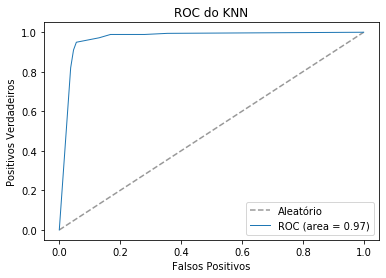

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test[:], probas[:,1])
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Aleatório')
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % roc_auc)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Positivos Verdadeiros')
plt.title('ROC do KNN')
plt.legend(loc="lower right")
plt.show()


In [6]:
for tp, fp, t in zip(tpr, fpr, thresholds):
    print('tp = %.2f, fp = %.2f, t=%.2f' % (tp, fp, t))

tp = 0.00, fp = 0.00, t=2.00
tp = 0.82, fp = 0.04, t=1.00
tp = 0.91, fp = 0.05, t=0.86
tp = 0.95, fp = 0.06, t=0.71
tp = 0.97, fp = 0.13, t=0.57
tp = 0.99, fp = 0.17, t=0.43
tp = 0.99, fp = 0.28, t=0.29
tp = 0.99, fp = 0.36, t=0.14
tp = 1.00, fp = 1.00, t=0.00


***Teste Estatístico de McNemmar***

Este teste permite verificar se dois modelos possuem a mesma proporção de erros.

Temos nossa hipótese nula H0: dois modelos possuem a mesma proporção de erros.

- Se essa hipótese for rejeitada, temos que os dois modelos apresentam proporções de erro diferentes, logo eles são estatisticamente diferentes (o melhor é o que apresentar melhores resultados, de acordo com outras métricas)
- Se falharmos em rejeitar essa hipótese, então não é possível afirmar que os modelos tem resultados diferentes.

Primeiro precisamos montar a matriz de contingência.

In [7]:
def build_contingence_table(Y, Y_pred_1, Y_pred_2):
    y1_and_y2 = 0
    y1_and_not_y2 = 0
    y2_and_not_y1 = 0
    not_y1_and_not_y2 = 0
    for y, y1, y2 in zip(Y, Y_pred_1, Y_pred_2):
        if y == y1 == y2:
            y1_and_y2 += 1
        elif y != y1 and y != y2:
            not_y1_and_not_y2 += 1
        elif y == y1 and y != y2:
            y1_and_not_y2 += 1
        elif y != y1 and y == y2:
            y2_and_not_y1 += 1
            
    contingency_table = [[y1_and_y2, y1_and_not_y2], 
                         [y2_and_not_y1, not_y1_and_not_y2]]
    
    return contingency_table

In [8]:
from statsmodels.stats.contingency_tables import mcnemar

In [9]:
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train, y_train)

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)

y_pred2 = knn2.predict(X_test)
y_pred3 = knn3.predict(X_test)

In [10]:
contingence_table = build_contingence_table(y_test, y_pred2, y_pred3)

import pprint

pprint.pprint(contingence_table)

[[259, 2], [6, 18]]


In [11]:
result = mcnemar(contingence_table, exact=True)
    
    
if result.pvalue >= 0.001:
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
else:
    print('statistic=%.3f, p-value=%.3e' % (result.statistic, result.pvalue))

# interpretando o p-value
alpha = 0.05
if result.pvalue > alpha:
    print('Mesma proporção de erros (falhou em rejeitar H0)')
else:
    print('Proporções de erros diferentes (rejeitou H0)')

statistic=2.000, p-value=0.289
Mesma proporção de erros (falhou em rejeitar H0)


# Exercícios

(1) Plote o ROC do resultado para k=3 e k=10

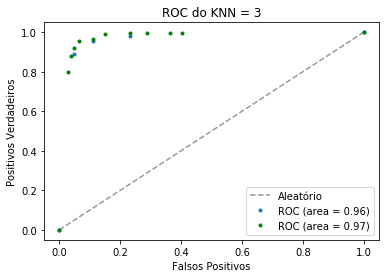

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

probas1 = knn.predict_proba(X_test)

fpr1, tpr1, thresholds = roc_curve(y_test[:], probas1[:,1])
roc_auc1 = auc(fpr1, tpr1)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

probas2 = knn.predict_proba(X_test)

fpr2, tpr2, thresholds = roc_curve(y_test[:], probas2[:,1])
roc_auc2 = auc(fpr2, tpr2)

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Aleatório')
plt.plot(fpr1, tpr1, '.',lw=1, label='ROC (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, 'g.', lw=1, label='ROC (area = %0.2f)' % roc_auc2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Positivos Verdadeiros')
plt.title('ROC do KNN = 3')
plt.legend(loc="lower right")


In [13]:
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix()

TypeError: contingency_matrix() missing 2 required positional arguments: 'labels_true' and 'labels_pred'

(2) Use o teste de McNemmar e responda: Comparando todos os modelos treinados com k=2 até k=10, quais pares de modelos apresentam resultados estatisticamente diferentes?